In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from calendar import day_name

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize':(15,7)},style="whitegrid")
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor

In [3]:
data_deal = r"C:\Users\Mishe\Downloads\massive.xlsx"
df = pd.read_excel(data_deal, parse_dates=['Месяц и год даты договора'])

In [44]:
df.head()

,ID проекта,ID корпуса,Проект,Локация,Город,Округ,Район,Адрес корпуса,Класс,Конструктив здания,...,Цена 1 кв.м первого появления в экспозиции,Бюджет покупки первого появления в экспозиции,Рост цены за 1 кв.м за период экспонирования,Рост бюджета покупки за период экспонирования,Дата актуальности данных,История участия объекта в сделках (ПДн),Дата регистрации материнской сделки,Дата договора материнской сделки,Количество повторных сделок,month
0,8343b893da2aba6cb6e653a6b2758707,5406d8908e2e8540565788e820118582,Мичуринский парк,Москва,Москва,ЗАО,Очаково-Матвеевское,"Озёрная ул., д. 44, к. 2.4",Комфорт,Монолит-панель-блоки,...,"246527,98","10748620,00","5,7%","5,7%",2024-03-01,2023-01-02 Договор участия 9a874f9791e5f2680af...,2023-01-26,2023-01-02 00:00:00,0,2023-01-01
1,a7e9392c9f33a09aafe185a03160adf6,dbb9905ef81eaa4d8b94a1392153346f,Михайловский парк,Москва,Москва,ЮВАО,Рязанский,"2-я Институтская ул., к. 1",Комфорт,Монолит-панель,...,"276829,99","6654993,00","-1,3%","-1,3%",2024-01-31,2019-05-02 Договор уступки 8720018455c063d043a...,2019-05-22,2019-05-02 00:00:00,1,2023-01-01
2,f84c01186fb55b637c38ada30f678061,76d373df5e11e5b8ffa9a3c5c6c06506,Академика Павлова,Москва,Москва,ЗАО,Кунцево,"Академика Павлова ул., к. 56",Комфорт,Монолит-панель,...,"321800,00","25261300,00","-10,9%","-10,9%",2024-01-09,2023-01-03 Договор участия ef1f8f86505acd8a4ce...,2023-01-19,2023-01-03 00:00:00,0,2023-01-01
3,49a3b5aa0c30b65c7de9faeadb5cb803,3a035c76c3224b5bd6b65d0225f60bea,Второй Нагатинский,Москва,Москва,ЮАО,Нагатино-Садовники,"2-й Нагатинский пр-д, вл. 2/2, к. 2",Комфорт,Монолит-панель,...,н/д,н/д,н/д,н/д,2024-02-01,2022-02-10 Договор участия 4c2164908913a85dbf8...,2022-03-04,2022-02-10 00:00:00,0,2023-01-01
4,a0c7577dac31343dc7422cbf446fb957,289475822563dd3838f8202afe79bc02,Бусиновский парк,Москва,Москва,САО,Западное Дегунино,"Коровинское ш., уч. 35/18, к. 21.4",Комфорт,Монолит-панель,...,н/д,н/д,н/д,н/д,2024-01-31,2023-01-06 Договор участия 7ff07d4566e8e35a0bc...,2023-01-17,2023-01-06 00:00:00,0,2023-01-01


In [54]:
date_col = "Месяц и год даты договора"
id_col = "ID лота"
seg_cols = ["Район", "Класс"]

room_col = "Универсальная комнатность"
fin_col = "Отделка по корпусу"

In [56]:
df = df.copy()
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col])

df["month"] = df[date_col].dt.to_period("M").dt.to_timestamp()
df = df.sort_values("month")

In [80]:
#y:сделки в месяц по сегменту
y_seg = (
    df.groupby(["month"] + seg_cols)[id_col]
      .nunique()
      .rename("y")
      .to_frame()
)

#делаем полный грид month×(район,класс)
all_months = pd.date_range(df["month"].min(), df["month"].max(), freq="MS")
all_segs = df[seg_cols].drop_duplicates()

full_index = (
    all_segs.assign(_k=1)
    .merge(pd.DataFrame({"month": all_months, "_k": 1}), on="_k")
    .drop(columns="_k")
    .set_index(["month"] + seg_cols)
    .sort_index()
)

panel = full_index.join(y_seg, how="left").fillna({"y": 0}).reset_index()

In [82]:
#признаки-распределения внутри сегмента: комнатность и отделка (счётчики сделок)
def add_pivot_counts(panel, df, col_name, prefix):
    tmp = (
        df.groupby(["month"] + seg_cols + [col_name])[id_col]
          .nunique()
          .rename("cnt")
          .reset_index()
          .pivot_table(index=["month"] + seg_cols, columns=col_name, values="cnt", fill_value=0)
    )
    tmp.columns = [f"{prefix}__{str(c)}" for c in tmp.columns]
    tmp = tmp.reindex(full_index.index, fill_value=0)
    out = panel.set_index(["month"] + seg_cols).join(tmp, how="left").fillna(0).reset_index()
    return out

panel = add_pivot_counts(panel, df, room_col, "room")
panel = add_pivot_counts(panel, df, fin_col, "fin")

#сезонность
panel["month_num"] = panel["month"].dt.month

In [84]:
panel = panel.sort_values(seg_cols + ["month"]).reset_index(drop=True)

dist_cols = [c for c in panel.columns if c.startswith("room__") or c.startswith("fin__")]
g = panel.groupby(seg_cols, sort=False)

panel["y_lag1"] = g["y"].shift(1)
panel["y_lag2"] = g["y"].shift(2)

#сдвиг на 1 месяц, чтобы не было утечки
panel["y_roll3_mean"] = g["y"].transform(
    lambda s: s.shift(1).rolling(window=3, min_periods=3).mean()
)

#лаг распределений
panel[dist_cols] = g[dist_cols].shift(1)

panel = panel.dropna().reset_index(drop=True)

y = panel["y"]
cat_features = seg_cols
num_features = ["month_num", "y_lag1", "y_lag2", "y_roll3_mean"] + dist_cols
X = panel[cat_features + num_features]

In [88]:
months = np.array(sorted(panel["month"].unique()))
n_splits = 5
fold_sizes = np.full(n_splits, len(months) // n_splits, dtype=int)
fold_sizes[:len(months) % n_splits] +=1

In [170]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
        ("num", "passthrough", num_features),
    ],
    remainder="drop",
)

model = CatBoostRegressor(random_state=42)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", model),
])

maes = []
start = 0
for i, fs in enumerate(fold_sizes, 1):
    test_months = months[start:start+fs]
    train_months = months[:start]
    start += fs

    if len(train_months) == 0:
        continue

    tr_idx = panel["month"].isin(train_months)
    te_idx = panel["month"].isin(test_months)

    X_tr, y_tr = X.loc[tr_idx], y.loc[tr_idx]
    X_te, y_te = X.loc[te_idx], y.loc[te_idx]

    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_te)
    pred = np.clip(pred, 0, None)  #сделки не могут быть отрицательными

    mae = mean_absolute_error(y_te, pred)
    maes.append(mae)
    print(f"Fold {i}: test months {test_months[0]}..{test_months[-1]}, MAE={mae:.3f}")

print("MAE mean:", float(np.mean(maes)))

Learning rate set to 0.037231
0:	learn: 59.0008664	total: 5.86ms	remaining: 5.85s
1:	learn: 57.3683553	total: 8.76ms	remaining: 4.37s
2:	learn: 55.9313806	total: 11.3ms	remaining: 3.77s
3:	learn: 54.4662816	total: 13.9ms	remaining: 3.45s
4:	learn: 53.0945812	total: 17.1ms	remaining: 3.4s
5:	learn: 51.6680947	total: 19.4ms	remaining: 3.21s
6:	learn: 50.3755683	total: 22.2ms	remaining: 3.15s
7:	learn: 49.1401978	total: 24.8ms	remaining: 3.07s
8:	learn: 47.8952380	total: 27.5ms	remaining: 3.03s
9:	learn: 46.7192726	total: 30.4ms	remaining: 3.01s
10:	learn: 45.7752016	total: 33.7ms	remaining: 3.03s
11:	learn: 44.7760367	total: 36.7ms	remaining: 3.02s
12:	learn: 43.7657286	total: 39.9ms	remaining: 3.03s
13:	learn: 42.8533121	total: 42.7ms	remaining: 3.01s
14:	learn: 41.8755322	total: 47.4ms	remaining: 3.11s
15:	learn: 41.0239696	total: 49.4ms	remaining: 3.04s
16:	learn: 40.2295661	total: 51.1ms	remaining: 2.96s
17:	learn: 39.3111479	total: 52.8ms	remaining: 2.88s
18:	learn: 38.4116992	total

In [172]:
oof_pred = pd.Series(index=panel.index, dtype=float)

maes = []
start = 0

for i, fs in enumerate(fold_sizes, 1):
    test_months = months[start:start+fs]
    train_months = months[:start]
    start += fs

    if len(train_months) == 0:
        continue

    tr_idx = panel["month"].isin(train_months)
    te_idx = panel["month"].isin(test_months)

    X_tr, y_tr = X.loc[tr_idx], y.loc[tr_idx]
    X_te, y_te = X.loc[te_idx], y.loc[te_idx]

    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_te)
    pred = np.clip(pred, 0, None)

    oof_pred.loc[te_idx] = pred

    mae = mean_absolute_error(y_te, pred)
    maes.append(mae)
    print(f"Fold {i}: test months {test_months[0]}..{test_months[-1]}, MAE={mae:.3f}")

print("MAE mean:", float(np.mean(maes)))

Learning rate set to 0.037231
0:	learn: 59.0008664	total: 3.39ms	remaining: 3.39s
1:	learn: 57.3683553	total: 7.63ms	remaining: 3.81s
2:	learn: 55.9313806	total: 11.3ms	remaining: 3.75s
3:	learn: 54.4662816	total: 16.4ms	remaining: 4.08s
4:	learn: 53.0945812	total: 20.5ms	remaining: 4.07s
5:	learn: 51.6680947	total: 23.3ms	remaining: 3.85s
6:	learn: 50.3755683	total: 26ms	remaining: 3.69s
7:	learn: 49.1401978	total: 28.3ms	remaining: 3.51s
8:	learn: 47.8952380	total: 31.1ms	remaining: 3.42s
9:	learn: 46.7192726	total: 34.9ms	remaining: 3.46s
10:	learn: 45.7752016	total: 37.9ms	remaining: 3.41s
11:	learn: 44.7760367	total: 40.7ms	remaining: 3.35s
12:	learn: 43.7657286	total: 43.5ms	remaining: 3.3s
13:	learn: 42.8533121	total: 45.9ms	remaining: 3.23s
14:	learn: 41.8755322	total: 48.5ms	remaining: 3.19s
15:	learn: 41.0239696	total: 51.3ms	remaining: 3.16s
16:	learn: 40.2295661	total: 54.2ms	remaining: 3.13s
17:	learn: 39.3111479	total: 56.4ms	remaining: 3.08s
18:	learn: 38.4116992	total: 

In [174]:
plot_df = panel.copy()
plot_df["y_true"] = y.values if isinstance(y, pd.Series) else y
plot_df["y_pred"] = oof_pred

In [120]:
plot_df

,month,Район,Класс,y,room__-,room__0,room__1,room__2,room__3,room__4,...,fin__missing,fin__Без отделки,fin__Предчистовая,fin__Чистовая,month_num,y_lag1,y_lag2,y_roll3_mean,y_true,y_pred
0,2023-04-01,Академический,Бизнес,3.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,5.0,0.0,0.0,4,5.0,15.0,9.333333,3.0,NaN
1,2023-05-01,Академический,Бизнес,5.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,3.0,0.0,0.0,5,3.0,5.0,7.666667,5.0,NaN
2,2023-06-01,Академический,Бизнес,18.0,0.0,0.0,4.0,1.0,0.0,0.0,...,0.0,5.0,0.0,0.0,6,5.0,3.0,4.333333,18.0,NaN
3,2023-07-01,Академический,Бизнес,21.0,0.0,0.0,8.0,4.0,1.0,0.0,...,0.0,18.0,0.0,0.0,7,18.0,5.0,8.666667,21.0,NaN
4,2023-08-01,Академический,Бизнес,14.0,0.0,0.0,8.0,4.0,2.0,0.0,...,0.0,21.0,0.0,0.0,8,21.0,18.0,14.666667,14.0,21.945608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461,2024-05-01,Ясенево,Бизнес,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5,0.0,0.0,0.000000,0.0,0.971032
2462,2024-06-01,Ясенево,Бизнес,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6,0.0,0.0,0.000000,0.0,0.971032
2463,2024-07-01,Ясенево,Бизнес,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7,0.0,0.0,0.000000,0.0,2.120859
2464,2024-08-01,Ясенево,Бизнес,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,8,0.0,0.0,0.000000,0.0,3.136696


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


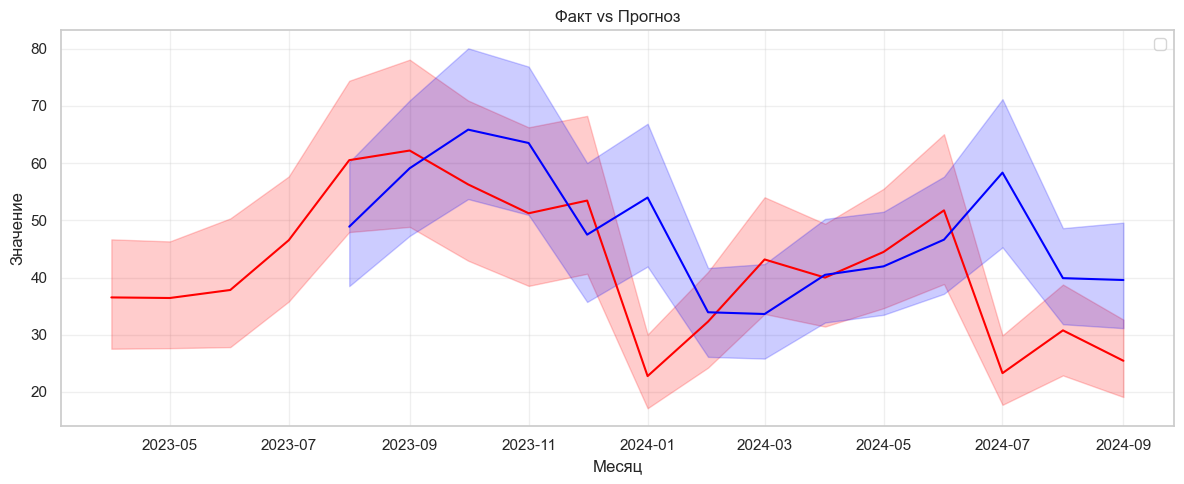

In [176]:
df = plot_df.sort_values("month")

plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='month', y='y_true', color='red')
sns.lineplot(data=df, x='month', y='y_pred', color='blue')

plt.title("Факт vs Прогноз")
plt.xlabel("Месяц")
plt.ylabel("Значение")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()